### Library Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import models as md
import cleaning as cl

%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, normalize, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

%load_ext autoreload
%autoreload 2

from imblearn.over_sampling import SMOTE


pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 90)


/Users/carterbouley/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


### Data Loading

In [2]:
df = pd.read_csv('credit_messy.csv')


In [3]:
df.columns

Index(['ID', 'CreditLimit', 'Gender', 'Education', 'MaritalStatus', 'Age',
       'RepayStatApr', 'RepayStatMay', 'RepayStatJun', 'RepayStatJul',
       'RepayStatAug', 'RepayStatSep', 'BillSep', 'BillAug', 'BillJul',
       'BillJun', 'BillMay', 'BillApr', 'PaymentSep', 'PaymentAug',
       'PaymentJul', 'PaymentJun', 'PaymentMay', 'PaymentApr', 'Default'],
      dtype='object')

In [4]:
df.head()

,ID,CreditLimit,Gender,Education,MaritalStatus,Age,RepayStatApr,RepayStatMay,RepayStatJun,RepayStatJul,RepayStatAug,RepayStatSep,BillSep,BillAug,BillJul,BillJun,BillMay,BillApr,PaymentSep,PaymentAug,PaymentJul,PaymentJun,PaymentMay,PaymentApr,Default
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Initial data exploration 

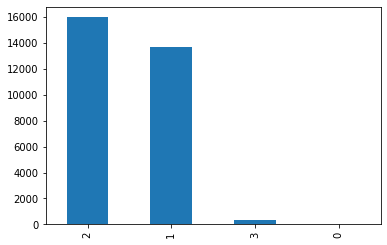

In [5]:
df.MaritalStatus.value_counts().plot(kind='bar')

In [6]:
df.MaritalStatus.value_counts()

2    15964
1    13659
3      323
0       54
Name: MaritalStatus, dtype: int64

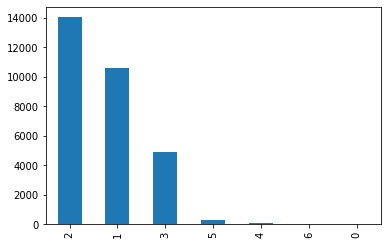

In [8]:
df.Education.value_counts().plot(kind='bar')

In [13]:
df = cl.FixEducation(df)

In [14]:
# Either mislabelled or incorrect data (marriage = 0, Education = 0)
# Given this is such a small proportion of our set, i've decided to drop the rows containing this information
df.Education.value_counts()

2    14024
1    10581
3     4873
4      123
Name: Education, dtype: int64

In [15]:
df.columns

Index(['ID', 'CreditLimit', 'Gender', 'Education', 'MaritalStatus', 'Age',
       'RepayStatApr', 'RepayStatMay', 'RepayStatJun', 'RepayStatJul',
       'RepayStatAug', 'RepayStatSep', 'BillSep', 'BillAug', 'BillJul',
       'BillJun', 'BillMay', 'BillApr', 'PaymentSep', 'PaymentAug',
       'PaymentJul', 'PaymentJun', 'PaymentMay', 'PaymentApr', 'Default'],
      dtype='object')

In [7]:
df.columns =['ID','CreditLimit','Gender','Education','MaritalStatus','Age',
        'RepayStatApr','RepayStatMay','RepayStatJun','RepayStatJul','RepayStatAug','RepayStatSep',
        'BillApr','BillMay','BillJun','BillJul','BillAug','BillSep',
        'PrevPaymentApr','PrevPaymentMay','PrevPaymentJun','PrevPaymentJul','PrevPaymentAug','PrevPaymentSep',
        'Default']



### Getting a feel for the distribution of the data to analyse points for feature engineering

The following cell will help us interpret our EDA by mapping the categorical variables based on the columns values

In [74]:
gender_dict ={1:'male', 2:'female'}
education_dict = {1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others'}
marriage_dict = {1 : 'married', 2 : 'single', 3 : 'others'}
df['Gender'] = df['Gender'].map(gender_dict)
df['Education'] = df['Education'].map(education_dict)
df['MaritalStatus'] = df['MaritalStatus'].map(marriage_dict)

In [75]:
df['CreditLimit'].describe() # Credit limit exploration, mean limit of 167,000 NT$.

count      29601.000000
mean      167550.544914
std       129944.020953
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: CreditLimit, dtype: float64

Converting .describe into USD for interpretation

In [76]:
for result in df['CreditLimit'].describe():
    print('$' + str(round(result*0.033, 2)))

$976.83
$5529.17
$4288.15
$330.0
$1650.0
$4620.0
$7920.0
$33000.0


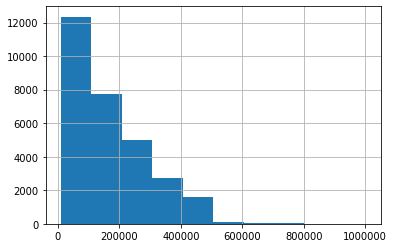

In [77]:
df.CreditLimit.hist()

In [78]:
total_default_pcnt = df['Default'].sum()/len(df.Default)
print('Average chance of default: ' + str(total_default_pcnt * 100) + '%')

Average chance of default: 22.31343535691362%


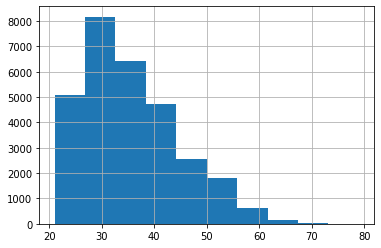

In [79]:
df.Age.hist()

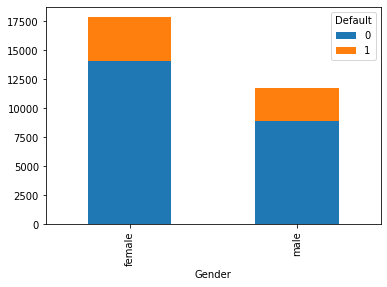

In [80]:
gender_df = pd.DataFrame(df.groupby(['Gender', 'Default']).size().unstack())
gender_df.plot(kind='bar', stacked = True)


In [81]:
gender_df['percentage_defaulted'] = round((gender_df[1]/(gender_df[0] + gender_df[1]))*100, 3)
gender_df

Default,0,1,percentage_defaulted
Gender,,,
female,14111,3744,20.969
male,8885,2861,24.357


In [82]:
education_df = pd.DataFrame(df.groupby(['Education', 'Default']).size().unstack())
                            
education_df

Default,0,1
Education,,
graduate school,8545,2036
high school,3640,1233
others,116,7
university,10695,3329


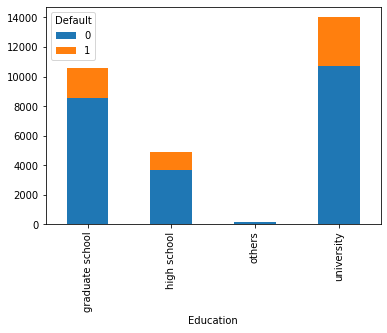

In [83]:
education_df = pd.DataFrame(df.groupby(['Education', 'Default']).size().unstack())
education_df.plot(kind='bar', stacked = True)

In [84]:
education_df['percentage_defaulted'] = round((education_df[1]/(education_df[0] + education_df[1]))*100, 3)
education_df

Default,0,1,percentage_defaulted
Education,,,
graduate school,8545,2036,19.242
high school,3640,1233,25.303
others,116,7,5.691
university,10695,3329,23.738


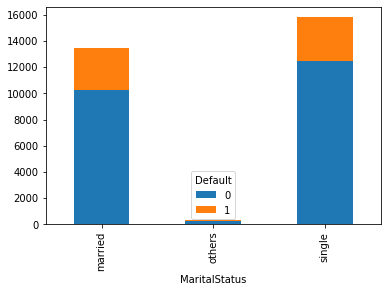

In [85]:
marriage_df = pd.DataFrame(df.groupby(['MaritalStatus', 'Default']).size().unstack())
marriage_df.plot(kind='bar', stacked = True)

In [86]:
marriage_df['percentage_defaulted'] = round((marriage_df[1]/(marriage_df[0] + marriage_df[1]))*100, 3)
marriage_df

Default,0,1,percentage_defaulted
MaritalStatus,,,
married,10285,3192,23.685
others,234,84,26.415
single,12477,3329,21.062


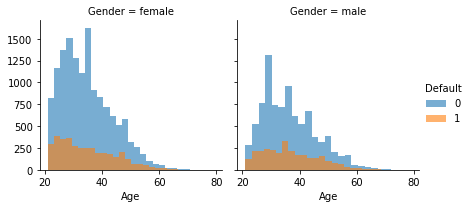

In [87]:
g = sns.FacetGrid(df, col='Gender', hue='Default')
g.map(plt.hist, 'Age', alpha=0.6, bins=25) #alpha is for opacity
g.add_legend()

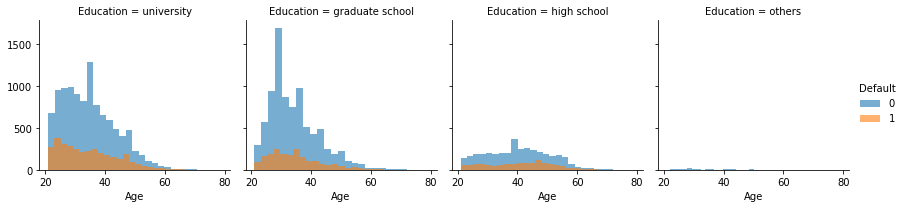

In [88]:
e = sns.FacetGrid(df, col='Education', hue='Default')
e.map(plt.hist, 'Age', alpha=0.6, bins=25) #alpha is for opacity
e.add_legend()

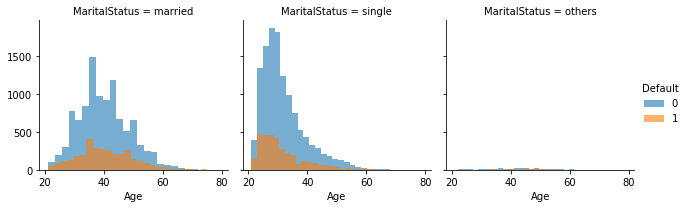

In [89]:
m = sns.FacetGrid(df, col='MaritalStatus', hue='Default')
m.map(plt.hist, 'Age', alpha=0.6, bins=25) #alpha is for opacity
m.add_legend()

In [90]:
df['average_bill'] =  (df['BillApr'] + df['BillMay'] + df['BillJun'] + df['BillJul'] + df['BillAug'] + df['BillSep'])/6                                                                           
df['average_payment'] = (df['PrevPaymentSep']  + df['PrevPaymentAug'] + df['PrevPaymentJul'] + df['PrevPaymentJun'] + df['PrevPaymentMay'] + df['PrevPaymentApr'])/6
df['total_payment'] = (df['PrevPaymentSep'] + df['PrevPaymentAug'] + df['PrevPaymentJul'] + df['PrevPaymentJun'] + df['PrevPaymentMay'] + df['PrevPaymentApr'])                                                                                  
df['average_percentage_of_bill_paid'] = (df['average_payment']/df['average_bill'])*100
df['bill_paid/credit_limit'] = (df['total_payment']/df['CreditLimit'])*100
df['average_bill_paid/credit_limit'] = (df['average_payment']/df['CreditLimit'])*100

In [1]:
# From this step above we found 784 cases of users who had 0 total bill, and 0 payments.
# Given they were not using the cards, and there was a range of defaults and non defaults, 
# we decided to remove this data as we were unsure on how someone who didn't use the card 
# could default.

In [92]:
drop_non_users =( df.loc[(df.average_bill == 0) & (df.total_payment == 0)]).index
df = df.drop(drop_non_users)

In [93]:
# Getting Dummies for Categorical Variables
df = pd.get_dummies(df)

In [94]:
df_test = df.loc[df.average_percentage_of_bill_paid == np.inf].index
df = df.drop(df_test)

In [95]:
df.to_csv('working_data.csv')

In [96]:
X = df[['Gender_female' ,'Gender_male' ,'Education_graduate school' ,'Education_high school', 'Education_others', 'Education_university','MaritalStatus_married', 'MaritalStatus_others',
       'MaritalStatus_single']]
# Here I selected the columns we wanted to investigate interactions for

In [100]:
features = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names(X.columns))
list_of_cols = []
for col in features:
    list_of_cols.append(col)
    
for col in list_of_cols:
    if features[col].sum() == 0:
        features = features.drop(columns = (col))
    else:
        pass
    
to_drop = features[['Gender_female', 'Gender_male', 'Education_graduate school',
       'Education_high school', 'Education_others', 'Education_university',
       'MaritalStatus_married', 'MaritalStatus_others',
       'MaritalStatus_single']]
features = features.drop(to_drop, axis = 1)

In [103]:
# Here I decided to change the negative status of repayment each month to 0 if no interest is paid, keeping the lags the same from then 
# on out.

cl.FixNegatives(df)


In [104]:
df = df.reset_index()

In [106]:
joined = pd.concat([df, features], axis = 1)

In [107]:
# joined.to_csv('allthedummies.csv')

## SVC model before resampling


In [5]:
X = joined.drop(columns = 'Default')
y = joined.Default

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

NameError: name 'joined' is not defined

## Fixing class imbalance

In [4]:
# Upsampling to reduce class imbalance

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=589, sampling_strategy = 1.0)
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = sm.fit_sample(X_train, X_test, y_train, y_test)
print(len(y_SMOTE))
print(y_SMOTE.sum())


NameError: name 'X_train' is not defined

In [110]:
scaler = StandardScaler()

X_SMOTE_train_scaled = scaler.fit_transform(X_SMOTE)
X_test_scaled = scaler.transform(X_test)

In [111]:
# SVM results with paramaters tuned with class imbalance fixed

In [112]:
###'Dont run unless you got a longlongtime'

# param_grid = [
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]


# scores = ['precision', 'recall']

# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(
#         SVC(max_iter = 1000), param_grid, scoring='%s_macro' % score
#     )
#     clf.fit(X_SMOTE_train_scaled, y_SMOTE)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = y_test, clf.predict(X_test_scaled)
#     print(classification_report(y_true, y_pred))
#     print()
    


In [113]:
# Tuning hyper-parameters for Precision

# Best parameters set found on development set:

# {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

# Grid scores on development set:

# 0.537 (+/-0.117) for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
# 0.537 (+/-0.117) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.446 (+/-0.107) for {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
# 0.446 (+/-0.107) for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.425 (+/-0.041) for {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
# 0.425 (+/-0.041) for {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.425 (+/-0.041) for {'C': 1000, 'gamma': 0.001, 'kernel': 'linear'}
# 0.425 (+/-0.041) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.589 (+/-0.063) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.671 (+/-0.101) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.586 (+/-0.054) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.683 (+/-0.117) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.526 (+/-0.078) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.621 (+/-0.073) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.520 (+/-0.149) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.569 (+/-0.098) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

# Detailed classification report:

# The model is trained on the full development set.
# The scores are computed on the full evaluation set.

#               precision    recall  f1-score   support

#            0       1.00      0.00      0.00      4489
#            1       0.22      1.00      0.36      1260

#     accuracy                           0.22      5749
#    macro avg       0.61      0.50      0.18      5749
# weighted avg       0.83      0.22      0.08      5749


# Tuning hyper-parameters for recall

# Best parameters set found on development set:

# {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

# Grid scores on development set:

# 0.527 (+/-0.084) for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
# 0.527 (+/-0.084) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.464 (+/-0.071) for {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
# 0.464 (+/-0.071) for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.443 (+/-0.064) for {'C': 100, 'gamma': 0.001, 'kernel': 'linear'}
# 0.443 (+/-0.064) for {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.443 (+/-0.064) for {'C': 1000, 'gamma': 0.001, 'kernel': 'linear'}
# 0.443 (+/-0.064) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'linear'}
# 0.505 (+/-0.003) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.502 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.505 (+/-0.002) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.501 (+/-0.002) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.502 (+/-0.018) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.503 (+/-0.002) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.504 (+/-0.103) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.508 (+/-0.012) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

# Detailed classification report:

# The model is trained on the full development set.
# The scores are computed on the full evaluation set.

#               precision    recall  f1-score   support

#            0       0.77      0.16      0.26      4489
#            1       0.22      0.83      0.34      1260

#     accuracy                           0.30      5749
#    macro avg       0.49      0.49      0.30      5749
# weighted avg       0.65      0.30      0.28      5749


In [114]:
svc_lin_clf = SVC(C=1, probability = True, max_iter = 20)


svc_lin_clf.fit(X_SMOTE_train_scaled, y_SMOTE)

/Users/carterbouley/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/carterbouley/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=20, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [115]:
y_true, y_pred = y_test, svc_lin_clf.predict(X_test)
y_probs = svc_lin_clf.predict_proba(X_test)


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4489
           1       0.00      0.00      0.00      1260

    accuracy                           0.78      5749
   macro avg       0.39      0.50      0.44      5749
weighted avg       0.61      0.78      0.68      5749



/Users/carterbouley/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [116]:
y_probs

array([[0.5814984, 0.4185016],
       [0.5814984, 0.4185016],
       [0.5814984, 0.4185016],
       ...,
       [0.5814984, 0.4185016],
       [0.5814984, 0.4185016],
       [0.5814984, 0.4185016]])

No Skill: ROC AUC=0.500
Support Vinear Machines: ROC AUC=0.500


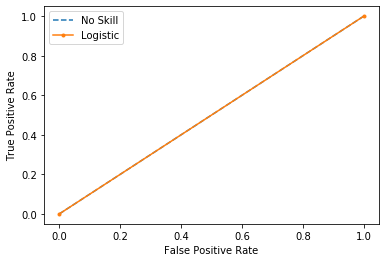

In [117]:

fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])


ns_probs = [0 for _ in range(len(y_probs[:,1]))]
ns_auc = roc_auc_score(y_test, ns_probs)
svm_auc = roc_auc_score(y_test, y_probs[:,1])


print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Support Vinear Machines: ROC AUC=%.3f' % (svm_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_probs[:,1])


plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### Logistic Regression model

In [118]:
log_reg_clf = LogisticRegression()

In [119]:
log_reg_clf.fit(X_SMOTE_train_scaled, y_SMOTE)

/Users/carterbouley/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [120]:
y_pred = log_reg_clf.predict(X_test_scaled)
y_probs = log_reg_clf.predict_proba(X_test_scaled)

In [121]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.8715909090909091,
  'recall': 0.8543105368678993,
  'f1-score': 0.8628642141973224,
  'support': 4489},
 '1': {'precision': 0.5151964418087472,
  'recall': 0.5515873015873016,
  'f1-score': 0.5327711766960522,
  'support': 1260},
 'accuracy': 0.787963124021569,
 'macro avg': {'precision': 0.6933936754498282,
  'recall': 0.7029489192276004,
  'f1-score': 0.6978176954466873,
  'support': 5749},
 'weighted avg': {'precision': 0.7934804500936011,
  'recall': 0.787963124021569,
  'f1-score': 0.7905182014556977,
  'support': 5749}}

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.764


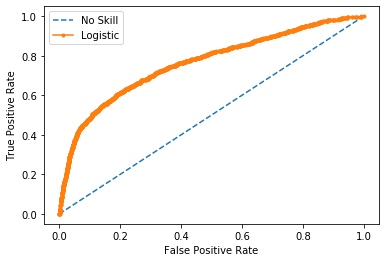

In [122]:

fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])


ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_probs[:,1])


print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_probs[:,1])


plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


In [176]:
len(log_reg_clf.coef_.T)

88

In [198]:
lennp.array([joined.columns[:]]).T

NameError: name 'lennp' is not defined

In [264]:
joined.columns

Index(['index', 'ID', 'CreditLimit', 'Age', 'RepayStatApr', 'RepayStatMay',
       'RepayStatJun', 'RepayStatJul', 'RepayStatAug', 'RepayStatSep',
       'BillApr', 'BillMay', 'BillJun', 'BillJul', 'BillAug', 'BillSep',
       'PrevPaymentApr', 'PrevPaymentMay', 'PrevPaymentJun', 'PrevPaymentJul',
       'PrevPaymentAug', 'PrevPaymentSep', 'Default', 'average_bill',
       'average_payment', 'total_payment', 'average_percentage_of_bill_paid',
       'bill_paid/credit_limit', 'average_bill_paid/credit_limit',
       'Gender_female', 'Gender_male', 'Education_graduate school',
       'Education_high school', 'Education_others', 'Education_university',
       'MaritalStatus_married', 'MaritalStatus_others', 'MaritalStatus_single',
       '1', 'Gender_female Education_graduate school',
       'Gender_female Education_high school', 'Gender_female Education_others',
       'Gender_female Education_university',
       'Gender_female MaritalStatus_married',
       'Gender_female MaritalStatus_

In [269]:
len((np.array([X_test.columns[:]]).T))

88

In [306]:
feature_importance=pd.DataFrame(np.hstack((np.array([X_test.columns[:]]).T, log_reg_clf.coef_.T)), columns=['feature', 'importance'])

In [307]:
feature_importance

mean = feature_importance.importance.mean()
std = feature_importance.importance.std()
coef_lista = []
for row in feature_importance.importance:
    new_calc = ((row - mean)/(std))
    coef_lista.append(new_calc)


In [308]:
feature_importance.importance.std()

0.11595884005315144

In [309]:
scaler = MinMaxScaler()

In [310]:
# coef_scaled = scaler.fit_transform(np.array(feature_importance.importance).reshape(-1,1))

In [311]:
feature_importance['coef_importance_scaled'] = coef_lista

In [313]:
importances = feature_importance.reindex(feature_importance.coef_importance_scaled.abs().sort_values(ascending = False).index)

In [317]:
importances

,feature,importance,coef_importance_scaled
4,RepayStatApr,0.919574,7.837433
11,BillMay,0.267128,2.210903
10,BillApr,-0.243926,-2.196292
2,CreditLimit,-0.220399,-1.993404
12,BillJun,0.172502,1.394876
16,PrevPaymentApr,-0.138535,-1.287430
6,RepayStatJun,0.134905,1.070645
14,BillAug,-0.108169,-1.025563
9,RepayStatSep,0.124936,0.984673
5,RepayStatMay,0.121991,0.959283
